# Community Detection (Label Propagation)

This notebook implements the custom community detection algorithm on the Cora dataset. Here, unsupervised label propagation is used to discover communities in an unlabeled network. The objective of this task is to validate the use of the custom label propagation algorithm, and evaluate its performance on an unsupervised community detection problem.

The following sections are included in this notebook:
1. **Library Imports**
- Importing the necessary modules, packages, and libraries
- Specifies dependencies and preferred versions
2. **Data Loading and Cleaning**
- Loads the Cora dataset with relevant features
- Finding an appropriate subgraph to visualize
3. **Data Visualization**
- Visualizes the subgraph
4. **Label Propagation Implementation**
- Implements the custom-built label propagation algorithm on the subgraph
- Visualizes the results 
- Evaluates the results using modularity
5. **Label Propagation Implementation (Changing Parameters)**
- Implements the custom-built label propagation algorithm with various maximum iterations
- Examines the effect on model performance

*For a more comprehensive overview of the community detection/label propagation algorithm, code structure, and metrics used, see the associated [README](README.md).*

### Library Imports
This section imports the packages and modules required to run label propagation. The following dependencies (with recommended versions) are required:
- Python 3.9.6
- Numpy 1.26.4
- PyTorch 2.8.0
- NetworkX 3.2.1
- Matplotlib 3.9.4

In [71]:
import numpy as np
import torch
import tempfile
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
from rice_ml.unsupervised_learning.communitydetection import *

### Data Loading and Cleaning
*Loading and preprocessing data*

The data used in this notebook comes from the Cora dataset, a common network used for graph-based machine learning algorithms. Although this dataset contains labeled nodes that can be used in supervised or semi-supervised algorithms, it can be adapted for unsupervised learning by retaining the structure of the graph itself without the associated labels. It has been selected for its relatively small size and simple structure.

The data is first loaded as a NetworkX graph. The total number of nodes and edges can be found.

In [72]:
# Loading the data
dataset_root = tempfile.mkdtemp()
cora_data = Planetoid(root=dataset_root, name='Cora', force_reload=True)
cora_data_new = cora_data[0]
G = to_networkx(cora_data_new, to_undirected=True)

Processing...
Done!


In [73]:
# Printing the number of nodes and edges, as well as example labels
print(f"Graph Statistics:\n{'-'*17}")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

Graph Statistics:
-----------------
Nodes: 2708
Edges: 5278


It is not feasible to visualize the structure of the entire graph, which is useful in evaluating community detection algorithms. We reduce the size by determining a set of connected components and using breadth-first search to construct a subgraph.

In [74]:
# Finding a suitable subgraph
largest_cc = max(nx.connected_components(G))
start_node = list(largest_cc)[1]
sub_nodes = list(nx.bfs_tree(G, start_node, depth_limit = 5))[:100]
sub_G = G.subgraph(sub_nodes)

In [75]:
print(f"Graph Statistics:\n{'-'*17}")
print(f"Nodes: {sub_G.number_of_nodes()}")
print(f"Edges: {sub_G.number_of_edges()}")

Graph Statistics:
-----------------
Nodes: 100
Edges: 136


This subgraph has only 100 nodes and 136 edges, making it more suitable for visualizing label propagation.

### Data Visualization
*Visualizing the network*

Once an appropriate subgraph has been selected, we are able to visualize it by plotting the nodes and edges. This allows us to determine whether the graph is suitable for community detection. We display the subgraph using the NetworkX `draw` command.

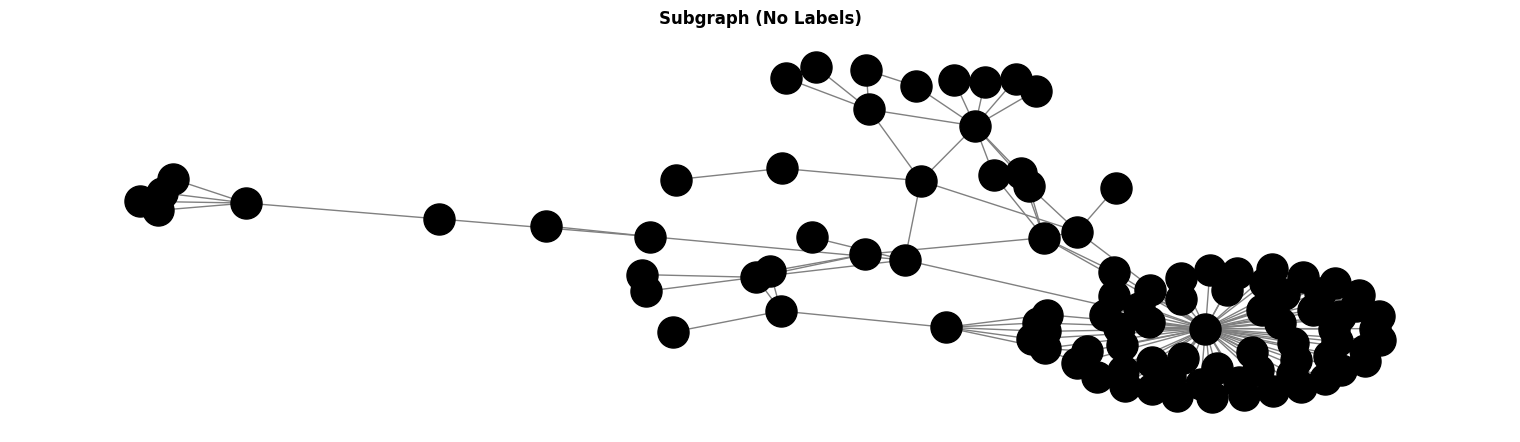

In [76]:
# Displaying the subgraph
plt.figure(figsize=(15, 4))
pos = nx.spring_layout(sub_G, seed=42)
nx.draw(sub_G, with_labels = False, node_color = 'black', node_size = 500, edge_color = 'gray', pos = pos)
plt.title("Subgraph (No Labels)", fontweight = 'bold')
plt.show()

This subgraph appears to have several groups that could be detected using unsupervised label propagation.

### Label Propagation Implementation
*Community detection using label propagation*

This section implements label propagation on the subgraph to produce labels for a set of communities derived from the unlabeled data. It carries out the model fit, visualization, and evaluation. We begin by creating an instance of the `label_propagation` class from the unsupervised learning package, and fitting it on the data.

This label propagation algorithm has the following specifications:
- **Maximum Iterations:** 100
- **Random State:** 438

In [77]:
# Performing label propagation and accessing communities
labeling = label_propagation(sub_G, max_iter = 100, random_state = 438)
labeling.propagation()
communities = labeling.get_communities('dict')

In [78]:
community_list = labeling.get_communities('list')
print(f"Label Propagation Results: \n{'-'*26}")
print(f"Number of communities: {len(community_list)}")
for i in range(len(community_list)):
    print(f"Number of nodes in Community {i}: {len(community_list[i])}")

Label Propagation Results: 
--------------------------
Number of communities: 4
Number of nodes in Community 0: 8
Number of nodes in Community 1: 9
Number of nodes in Community 2: 63
Number of nodes in Community 3: 20


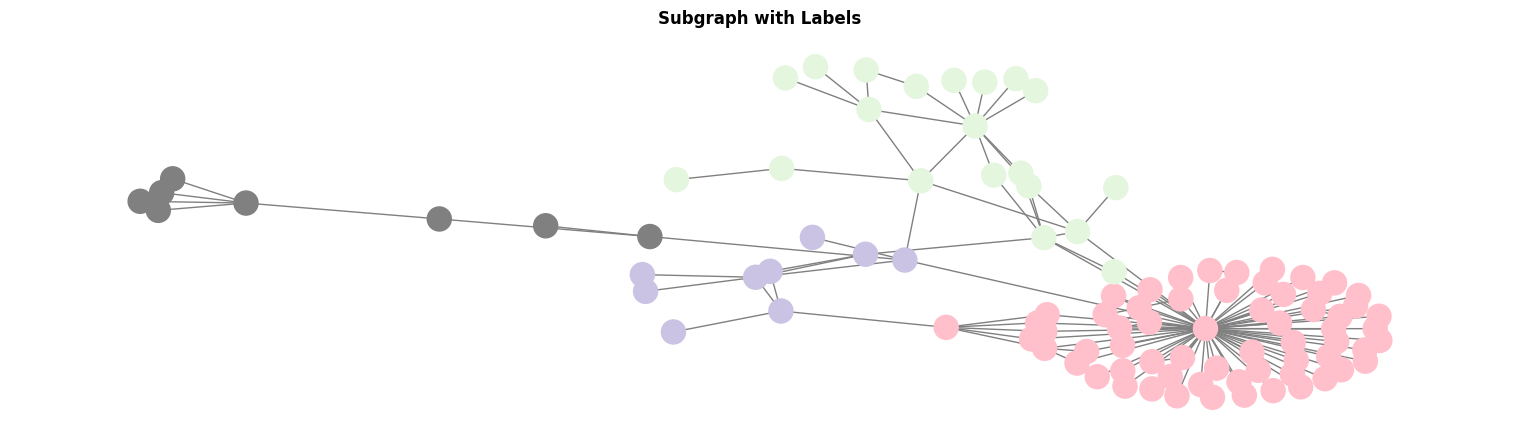

In [79]:
node_colors = {}
colors = ['gray', '#CBC3E3', 'pink', '#E5F6DF']

for i, (label, nodes) in enumerate(communities.items()):
    for node in nodes:
        node_colors[node] = colors[i % len(colors)]

color_list = [node_colors[node] for node in sub_G.nodes()]

plt.figure(figsize=(15, 4))
pos = nx.spring_layout(sub_G, seed = 42)
nx.draw(sub_G, with_labels = False, node_color = color_list, node_size = 300, edge_color = 'gray', pos = pos)
plt.title("Subgraph with Labels", fontweight = 'bold')
plt.show()

The label propagation algorithm returned four communities for the given subgraph, with varying sizes. The first community has 8 nodes, the second has 9, the third and largest has 63, and the fourth has 20. The visualization of the label propagation results appears accurate, with connected nodes sharing the same label. For a more quantitative evaluation metric, we calculate modularity using NetworkX.

In [80]:
# Computing modularity
communities_list = [set(nodes) for nodes in communities.values()]
mod = modularity(sub_G, communities_list)
print(f"Modularity: {mod:.3f}")

Modularity: 0.505


The modularity score for the label propagation algorithm is around 0.50, which is a moderate to strong value. This indicates that the graph is appropriately partitioned into communities, supporting the use of the custom label propagation model for community detection.

### Label Propagation Implementation (Changing Parameters)
*Altering maximum number of iterations*

This section implements the custom label propagation algorithm on the subgraph, but systematically changes a parameter in the model to determine the effects on performance. It evaluates the model for different maximum iterations, using modularity as the primary metric.

In [81]:
# Arrays for modularity and maximum iterations
max_iter_array = np.linspace(1, 200, 10)
mod_array = np.full(len(max_iter_array), np.nan)

# Calculating modularity for each maximum iteration
for i in range(len(max_iter_array)):
    labeling = label_propagation(sub_G, max_iter = int(max_iter_array[i]), random_state = 438)
    labeling.propagation()
    communities = labeling.get_communities('dict')
    communities_list = [set(nodes) for nodes in communities.values()]
    mod = modularity(sub_G, communities_list)
    mod_array[i] = mod

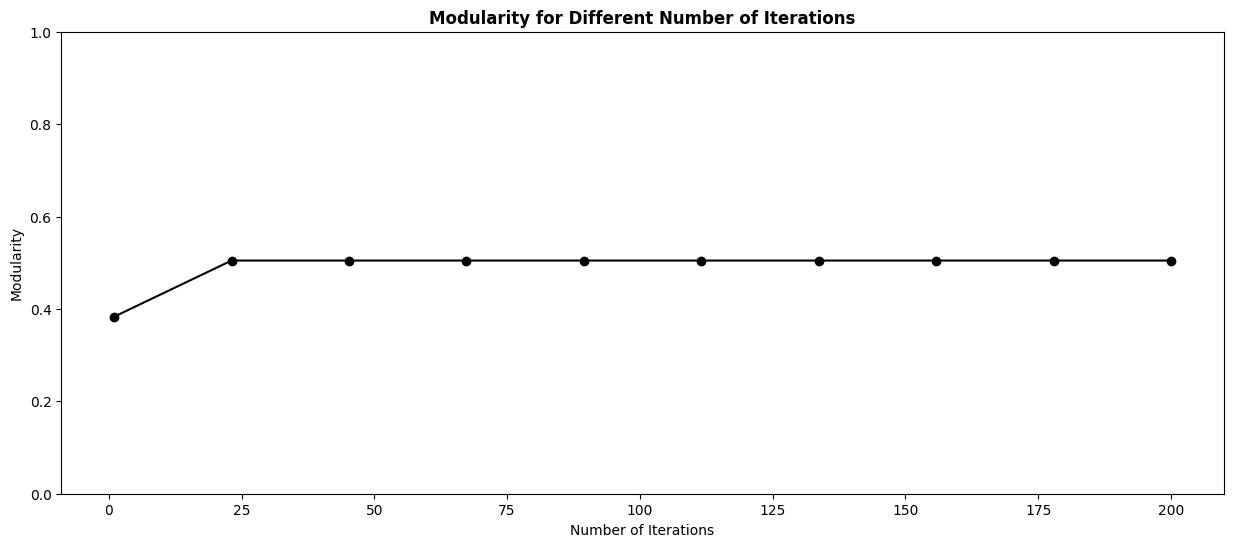

In [82]:
# Plotting the change in modularity across different numbers of maximum iterations
plt.figure(figsize = (15, 6))
plt.plot(max_iter_array, mod_array, 'black')
plt.scatter(max_iter_array, mod_array, color = 'black')
plt.title("Modularity for Different Number of Iterations", fontweight = 'bold')
plt.xlabel("Number of Iterations")
plt.ylabel("Modularity")
plt.ylim(0, 1)
plt.show()

The modularity score begins low and increases as the number of iterations increase, up to around 25. Beyond this point, the modularity remains approximately the same regardless of the number of iterations, indicating that changing this parameter has minimal effect on algorithm performance. The original use of 100 iterations is suitable.